# <center>VMAT Tutorial </center>

Volumetric Modulated Arc Therapy (VMAT) has increasingly become the preferred treatment method for many disease sites, primarily due to its fast plan delivery and dose distribution comparable to that of IMRT. However, the optimization of numerous apertures and their corresponding monitor units results in challenging large-scale non-convex optimization problems. To address these challenges, researchers often resort to computationally efficient heuristic methods. Having a globally optimal solution as a benchmark can significantly aid in the development and validation of new VMAT algorithms (see [vmat_optimization.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/benchmark_algorithms/vmat_optimization.ipynb) notebook).

In this notebook, we introduce a VMAT optimization algorithm based on our recent publications ([Dursun et al 2021](https://iopscience.iop.org/article/10.1088/1361-6560/abee58/meta) and [Dursun et al 2023](https://iopscience.iop.org/article/10.1088/1361-6560/ace09e/meta)). This algorithm, called Sequential Convex Programming (SCP), solves a sequence of convex optimization problems that converge to the original non-convex VMAT problem. This technique should not be confused with hierarchical optimization (also known as prioritized optimization), which we utilized in our publication ([Dursun et al 2023](https://iopscience.iop.org/article/10.1088/1361-6560/ace09e/meta)) to automate the planning process. The SCP-VMAT algorithm with hierarchical optimization will be shared in a separate repository ([ECHO-VMAT](https://github.com/PortPy-Project/ECHO-VMAT)). The SCP technique can, in principle, be used in conjunction with any automation technique, including AI-based methods (see [dose_prediction_pipeline.ipynb](https://githubcom/PortPy-Project/PortPy/blob/master/examples/AI_tutorials/dose_prediction_pipeline.ipynb) notebook).

The SCP algorithm employs both local and global search strategies: a global search with a large step-size and a less accurate convex approximation is followed by a local search with a small step-size and an accurate convex approximation (for a detailed explanation, please refer to [Dursun et al 2021](https://iopscience.iop.org/article/10.1088/1361-6560/abee58/meta) and  [Dursun et al 2023](https://iopscience.iop.org/article/10.1088/1361-6560/ace09e/meta)).

**Note**: The VMAT module is in its early stages of development. This work was originally written in Matlab, and we are in the process of porting it to Python. If you have any questions or suggestions, please feel free to reach out to us.

### This example demonstrates the following main functionalities of portpy.photon.vmat module:


1. Accessing the portpy beam data as a set of dicrete beams for vmat control points
    (DataExplorer class)
    
2. Creating Arcs based upon the beam ids (Arcs class)

3. Creating a simple VMAT plan through integration with [CVXPy](https://www.cvxpy.org/) package
    (Plan class, VmatScpOptimization class)

4. Visualising the plan (e.g., dose distribution, DVH)
   (Visualization class)

5. Evaluating the plan (e.g., max/mean/DVH points, established clinical metrics)
    (Evaluation class)

6. Saving the plan and solution for future uses
    (Utils)

7. Saving optimal plan in RT-DICOM format which can be imported to any TPS


### 1) Accessing the portpy data (DataExplorer class)
 To start using this resource, users are required to download the latest version of the dataset, which can be found [here](https://drive.google.com/drive/folders/1nA1oHEhlmh2Hk8an9e0Oi0ye6LRPREit). Then, the dataset can be accessed as demonstrated below.



In [22]:
import sys
sys.path.append('..')

In [23]:
# If you're running PortPy for the first time, you need to install the requirements 
# !pip install -r ..\requirements.txt

In [24]:
import portpy.photon as pp
import numpy as np
import os

In [25]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)

In [26]:
data.patient_id = 'Lung_Patient_3'
# display the data of the patient in console or browser.
beams_df, structs_df = data.display_patient_metadata(return_beams_df=True, return_structs_df=True)
beams_df.head()
# display in browser rather than console. Set in_browser to True
# data.display_patient_metadata(in_browser=True)

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': 47.79601, 'y_mm': -1.963873, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': 47.79601, 'y_mm': -1.963873, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': 47.79601, 'y_mm': -1.963873, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': 47.79601, 'y_mm': -1.963873, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': 47.79601, 'y_mm': -1.963873, 'z_mm': ...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


In [6]:
# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

# Select beam ids based upon target location. We select beam ids from 0 to 36 based upon beams metadata
beam_ids = np.arange(0, 37) #  users can modify this based upon their beam selection
beams = pp.Beams(data, beam_ids=beam_ids)

# load clinical criteria from the config files for which plan to be optimized
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# Loading hyper-parameter values for optimization problem
protocol_name = 'Lung_2Gy_30Fx_vmat'
vmat_opt_params = data.load_config_opt_params(protocol_name=protocol_name)

# # Creating optimization structures (i.e., Rinds, PTV-GTV)
structs.create_opt_structures(opt_params=vmat_opt_params,
                              clinical_criteria=clinical_criteria)

# Loading influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

Creating optimization structures.. It may take some time due to dilation
Optimization structures created!!
Creating BEV..
Loading sparse influence matrix...
Done


### 2) Creating Arcs based upon the beam ids

In [7]:
# Assign discrete beam/control_point_ids to arcs and create arcs dictionary.
# Below is an example of creating 2 arcs. Users can create single or multiple arcs.
arcs_dict = {'arcs': [{'arc_id': "01", "control_point_ids": beam_ids[0:int(len(beam_ids) / 2)]},
                      {'arc_id': "02", "control_point_ids": beam_ids[int(len(beam_ids) / 2):]}]}
# Create an object of Arcs class
arcs = pp.Arcs(arcs_dict=arcs_dict, inf_matrix=inf_matrix)

# Create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria, arcs=arcs)


### 3) Optimize VMAT plan using sequential convex programming (PortPy.Photon.VmatScp module)



In [18]:

# Initialize Optimization
vmat_opt = pp.VmatScpOptimization(my_plan=my_plan,
                                  opt_params=vmat_opt_params)
# Run Sequential convex algorithm for optimising the plan. The final result will be stored in sol and convergence will store the convergence history (i.e., results of each iteration)
sol, convergence = vmat_opt.run_sequential_cvx_algo(solver='MOSEK', verbose=True)

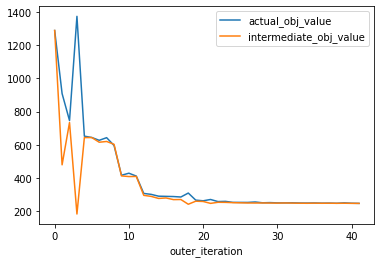

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
# Visualize convergence. The convergence dataframe contains the following columns:
df = pd.DataFrame(convergence, columns=['outer_iteration', 'inner_iteration', 'step_size_f_b', 'forward_backward', 'intermediate_obj_value', 'actual_obj_value', 'accept'])
# We can, for example, plot the actual and intermediate objective values against the outer iteration
df.plot(x='outer_iteration', y=['actual_obj_value', 'intermediate_obj_value'])
plt.show()

### 4) Visualizing the plan (Visualization class)

Skipping Structure HEART as it is not within calculation box.


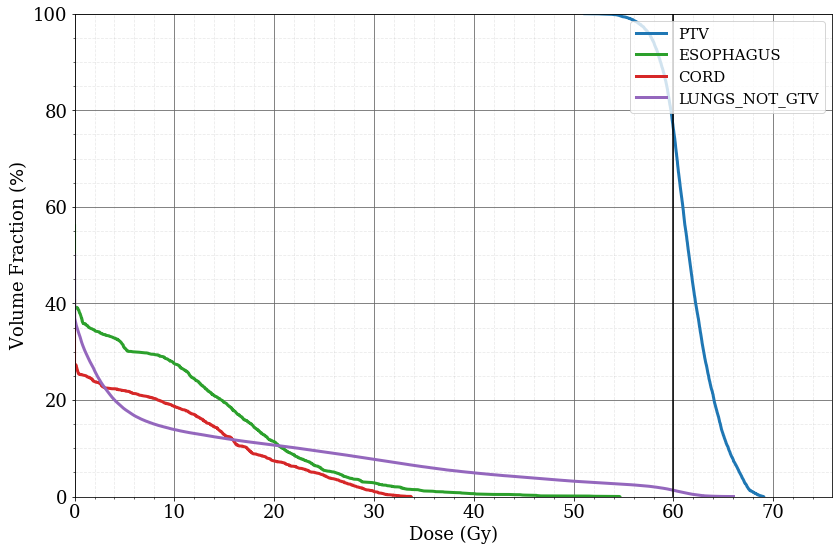

In [31]:
# plot dvh for the above structures
fig, ax = plt.subplots(figsize=(12, 8))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNGS_NOT_GTV']
pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, ax=ax)
plt.show()

<Axes: title={'center': 'Axial View - Slice #: 60'}>

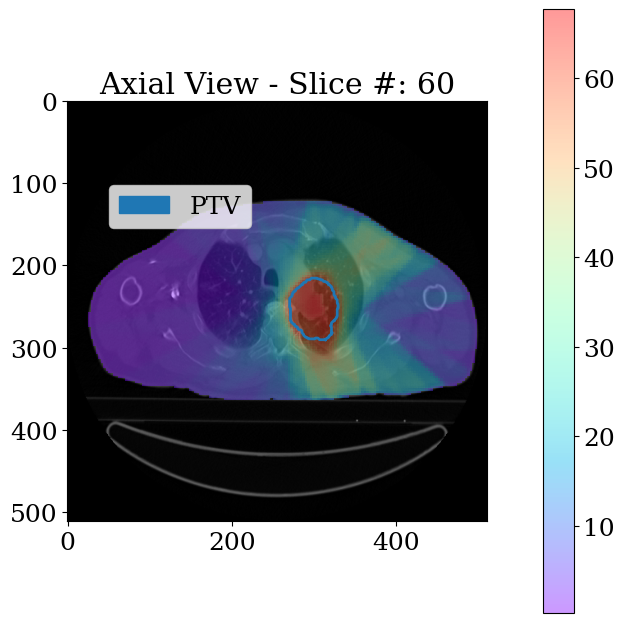

In [14]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Visualization.plot_2d_slice(my_plan=my_plan, sol=sol, slice_num=60, struct_names=['PTV'])

### 5) Evaluating the plan (Evaluation class)
The Evaluation class offers a set of methods for quantifying the optimized plan. If you need to compute individual dose volume metrics, you can use methods such as *get_dose* or *get_volume*. Furthermore, the class also facilitates the assessment of the plan based on a collection of metrics, such as mean, max, and dose-volume histogram (DVH), as specified in the clinical protocol. This capability is demonstrated below


In [15]:
# visualize plan metrics and compare them against the clinical criteria
pp.Evaluation.display_clinical_criteria(my_plan, sol=sol, clinical_criteria=clinical_criteria)
# The Evaluation class also has methods to extract different DVH metrics (e.g., get_dose(sol, struct, volume_per), get_volume(sol: struct dose_value_gy)))

,constraint,structure_name,Limit,Goal,Plan Value
0,max_dose,GTV,69.0Gy,66.0Gy,69.00
1,max_dose,PTV,69.0Gy,66.0Gy,69.00
2,max_dose,ESOPHAGUS,66.0Gy,,54.59
3,mean_dose,ESOPHAGUS,34.0Gy,21.0Gy,5.91
4,V(60.0Gy),ESOPHAGUS,17.0%,,0.00
5,max_dose,HEART,66.0Gy,,0.00
6,mean_dose,HEART,27.0Gy,20.0Gy,0.00
7,V(30.0Gy),HEART,50.0%,,0.00
8,V(30.0Gy),HEART,,48.0%,0.00
9,max_dose,LUNG_L,66.0Gy,,66.00


### 6) Saving and loading the plan for future use (utils)


In [16]:
# Comment/Uncomment these lines to save and load the pickle file for plans and optimal solution from the directory
pp.save_plan(my_plan, plan_name='my_plan_vmat.pkl', path=os.path.join(r'C:\temp', data.patient_id))
pp.save_optimal_sol(sol, sol_name='sol_vmat.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# my_plan = pp.load_plan(plan_name='my_plan_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# sol = pp.load_optimal_sol(sol_name='sol_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))

### 7) Visualizing and Evaluating the plan in TPS (Utils class)
The following code generates an RT Plan DICOM file using the above solution, which can be imported into any TPS for final evaluation. 
We suggest you to go through notebook [eclipse_integration.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/eclipse_integration.ipynb) to learn about how to address the dependencies between optimization and final dose calculation before importing the plan into TPS.

In [17]:
# write plan to dicom file
# create dicom RT Plan file to be imported in TPS
out_rt_plan_file = r'C:\Temp\Lung_Patient_3\rt_plan_portpy_vmat.dcm'  # change this file directory based upon your needs
in_rt_plan_file = r'C:\Temp\Lung_Patient_3\rt_plan_echo_vmat.dcm'  # change this directory as per your
pp.write_rt_plan_vmat(my_plan=my_plan, in_rt_plan_file=in_rt_plan_file, out_rt_plan_file=out_rt_plan_file)
print('Done')